In [10]:
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt

if not os.path.exists("data/cora.cites"):
    os.system("wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz")
    os.system("tar -xvf cora.tgz")
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"{device= }")
edges = pd.read_csv("data/cora.cites", header=None, sep="\t")
edges.columns = ["src", "tgt"]
edges


device= 'mps'


,src,tgt
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x1424,x1425,x1426,x1427,x1428,x1429,x1430,x1431,x1432,label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2704,1128977,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2705,1128978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2706,117328,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


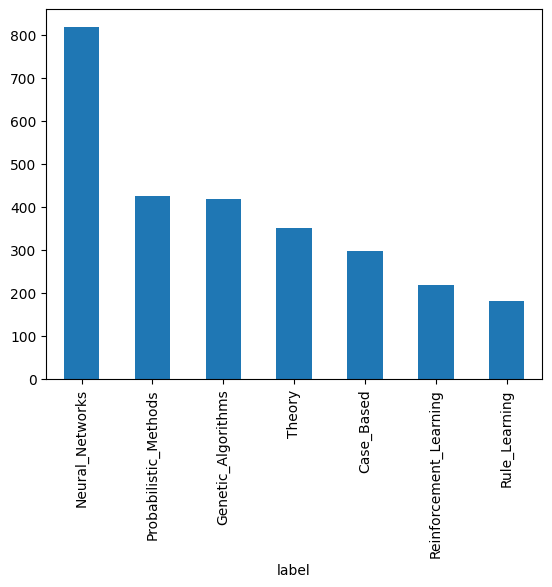

In [11]:
from sklearn.preprocessing import LabelEncoder
verts = pd.read_csv("data/cora.content", header=None, sep="\t")
cols = ["id"]
cols.extend([f"x{i}" for i in range(len(verts.columns) - 2)])
cols.append("label")
verts.columns = cols

verts['label'].value_counts().plot.bar()
le = LabelEncoder()
labels = le.fit_transform(verts["label"])
verts['label'] = labels
verts


In [12]:
# map id to node index
idx_map = {i: idx for idx, i in enumerate(verts["id"].unique())}
idx_map[31336]

0

In [13]:
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric import transforms as T
from torch_geometric.transforms import RandomNodeSplit, AddSelfLoops

x = verts[[f"x{i}" for i in range(len(verts.columns) - 2)]]
x = torch.from_numpy(x.to_numpy()).to(torch.float32)
y = torch.from_numpy(verts["label"].to_numpy()).to(torch.long)
src = [idx_map[i] for i in edges["src"]]
tgt = [idx_map[i] for i in edges["tgt"]]
edge_idx = torch.tensor([src, tgt], dtype=torch.long)

data = Data(x=x, edge_index=edge_idx, y=y)
data

Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708])

In [14]:
transform = T.Compose([AddSelfLoops(), RandomNodeSplit(num_test=0.2, num_val=0.1)])
data = transform(data)
data.validate(raise_on_error=True)
print(data.keys)
print(data["x"])
print(data.num_nodes)
print(data.num_edges)
print("isolated nodes:", data.has_isolated_nodes())
print("self loops:", data.has_self_loops())
data


['train_mask', 'edge_index', 'val_mask', 'y', 'x', 'test_mask']
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
2708
8137
isolated nodes: False
self loops: True


Data(x=[2708, 1433], edge_index=[2, 8137], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [15]:
import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn


class GCN(torch.nn.Module):
    def __init__(self, in_feats, h_feats, outputs) -> None:
        super().__init__()
        self.c1 = gnn.GCNConv(in_feats, h_feats)
        self.c2 = gnn.GCNConv(h_feats, outputs)
        # self.gat = gnn.GAT(in_feats, 64, num_layers=2, out_channels=outputs)

    def forward(self, data):
        x, edge_idx = data.x, data.edge_index

        h = self.c1(x, edge_idx)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.c2(h, edge_idx)
        # h = self.gat(x, edge_idx)

        return F.log_softmax(h, dim=1)


In [16]:
from tqdm import tqdm
from torchmetrics import F1Score

# device = "cpu" # if gat, must not be mps
print("device:", device)
num_classes = len(data.y.unique())
avg = None  # "none"

metric = F1Score(
    task="multiclass",
    num_classes=num_classes,
    # average=avg,
).to(device)

model = GCN(data.num_edge_features, 16, num_classes).to(device)
data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
train_y = data.y[data.train_mask]
val_y = data.y[data.val_mask]
model.train()
t = tqdm(range(500))
for epoch in t:
    optimizer.zero_grad()
    pred = model(data)
    loss = F.nll_loss(pred[data.train_mask], train_y)
    loss.backward()
    optimizer.step()
    pred = pred.argmax(1)

    correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    acc = int(correct) / int(data.train_mask.sum())
    val_correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    val_acc = int(val_correct) / int(data.val_mask.sum())

    f1 = metric(pred[data.train_mask], train_y)
    val_f1 = metric(pred[data.val_mask], val_y)
    if avg != "none":
        t.set_description(
            f"acc: {acc:.4f} | val_acc: {val_acc:.4f} | f1: {f1:.4f} | val_f1: {val_f1:.4f}"
        )

if avg == "none":
    print(f"acc: {acc:.4f} | val_acc: {val_acc:.4f} | f1: {f1} | val_f1: {val_f1}")


device: mps


acc: 0.9420 | val_acc: 0.8524 | f1: 0.9420 | val_f1: 0.8524: 100%|██████████| 500/500 [00:13<00:00, 36.75it/s]


In [17]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f"Accuracy: {acc:.4f}")
metric = F1Score(task="multiclass", num_classes=num_classes,average=avg)
target = data.y[data.test_mask].to("cpu")

f"f1: {metric(pred[data.test_mask].to('cpu'), target)}"


Accuracy: 0.8487


'f1: tensor([0.8421, 0.9317, 0.8675, 0.8889, 0.8478, 0.8451, 0.6761])'

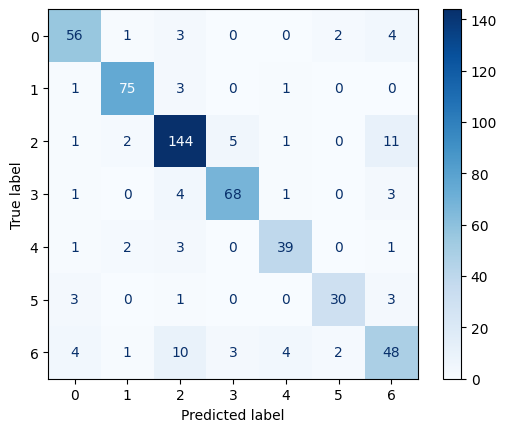

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(target,pred[data.test_mask].to('cpu'))
disp=ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.show()